In [1]:
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

data_dir = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset'

# Load images and labels
X = []
y = []

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    for image_file in os.listdir(label_path):
        image_path = os.path.join(label_path, image_file)
        img = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(label)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Normalization (range becomes [0,1])
X = np.array([image / 255.0 for image in X])

# Split into features and labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Displaying the shapes of the split datasets
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Training set: 900 samples
Validation set: 112 samples
Test set: 113 samples


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (224, 224, 3)

model = Sequential()

# Convolutional layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 4 neurons (one for each class) and softmax activation
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

# Convert labels to one-hot encoded vectors
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_val_one_hot = to_categorical(y_val, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train_one_hot, batch_size=32)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) / 32,  
    epochs=5, 
    validation_data=(X_val, y_val_one_hot),
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Convert one-hot encoded labels back to original labels for evaluation
y_test_original = label_encoder.inverse_transform(y_test)



Epoch 1/5
28/28 [==============================] - 35s 1s/step - loss: 1.1042 - accuracy: 0.5356 - val_loss: 0.9331 - val_accuracy: 0.5446
Epoch 2/5
28/28 [==============================] - 33s 1s/step - loss: 0.8557 - accuracy: 0.5989 - val_loss: 0.7543 - val_accuracy: 0.8304
Epoch 3/5
28/28 [==============================] - 33s 1s/step - loss: 0.7105 - accuracy: 0.6811 - val_loss: 0.6509 - val_accuracy: 0.8482
Epoch 4/5
28/28 [==============================] - 33s 1s/step - loss: 0.5948 - accuracy: 0.7789 - val_loss: 0.5018 - val_accuracy: 0.8393
Epoch 5/5
4/4 [==============================] - 1s 258ms/step


In [4]:
# Convert y_test_original to numeric labels for consistency
y_test_original_numeric = label_encoder.transform(y_test_original)

# Display evaluation metrics
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_original_numeric, y_pred_classes))




Confusion Matrix:
[[19  4  5  2]
 [ 0 19  2  0]
 [ 0  0 26  0]
 [ 0  0  0 36]]


In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute accuracy
accuracy = accuracy_score(y_test_original_numeric, y_pred_classes)
print(f"\nAccuracy: {accuracy:.4f}")

# Compute precision, recall, and F1-score for each class
precision = precision_score(y_test_original_numeric, y_pred_classes, average=None)
recall = recall_score(y_test_original_numeric, y_pred_classes, average=None)
f1 = f1_score(y_test_original_numeric, y_pred_classes, average=None)

# Display precision, recall, and F1-score for each class
for i in range(len(label_encoder.classes_)):
    print(f"\nClass: {label_encoder.classes_[i]}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-Score: {f1[i]:.4f}")



Accuracy: 0.8850

Class: Cloudy
Precision: 1.0000
Recall: 0.6333
F1-Score: 0.7755

Class: Rain
Precision: 0.8261
Recall: 0.9048
F1-Score: 0.8636

Class: Shine
Precision: 0.7879
Recall: 1.0000
F1-Score: 0.8814

Class: Sunrise
Precision: 0.9474
Recall: 1.0000
F1-Score: 0.9730


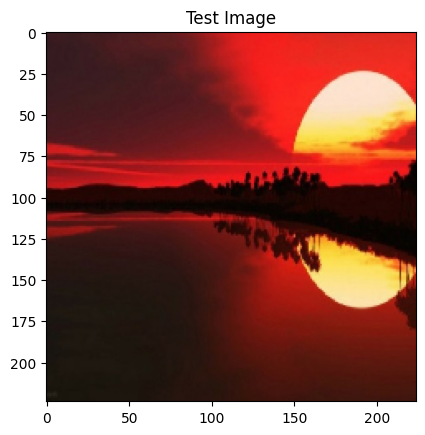

1/1 [==============================] - 0s 31ms/step

Predicted Class: Sunrise


In [6]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


# Load a new image for prediction
new_image_path = '/kaggle/input/multiclass-weather-dataset/Multi-class Weather Dataset/Sunrise/sunrise101.jpg'  # Replace with the path to your new image
new_img = load_img(new_image_path, target_size=(224, 224))  # Adjust target size based on your model's input size
new_img_array = img_to_array(new_img)
new_img_array = new_img_array / 255.0  # Normalize the pixel values

plt.imshow(new_img)
plt.title('Test Image')
plt.show()

# Expand the dimensions to match the input shape expected by the model
new_img_array = np.expand_dims(new_img_array, axis=0)

# Make the prediction
prediction = model.predict(new_img_array)
predicted_class_index = np.argmax(prediction)
predicted_class = label_encoder.classes_[predicted_class_index]

# Display the result
print(f"\nPredicted Class: {predicted_class}")